# LGBM을 활용한 베이스라인

In [1]:
import pandas as pd
import os
import random
from tqdm import tqdm
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import pickle

## 1. 데이터 로딩

In [2]:
data_dir = '/opt/ml/project/data/' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'total_data_v2.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path, parse_dates=['Timestamp', 'test_start_time', 'test_end_time']) 
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [3]:
users_file_path = os.path.join(data_dir, 'cv1_users.pickle')
with open(users_file_path,'rb') as f:
    users = pickle.load(f)
train_users, test_users = users['train_users'], users['test_users']

## 2. Feature Engineering

In [4]:
def calculate_elapsdTime(df):

    for offset in [86400]:
        time_cond = df[f'elapsedTime'] < offset
        global_elapsedTime_mean = df.loc[time_cond, 'elapsedTime'].mean()
        
        roll_df = df[['userID', 'elapsedTime']].copy()
        roll_df.loc[~time_cond, 'elapsedTime'] = np.NaN
        for window_size in [3, 5, 10, 30, 50, 100, 200]:
            df[f'roll_elapsedTime{offset}_mean{window_size}'] = \
                roll_df.groupby(['userID'])[f'elapsedTime'].rolling(window_size, min_periods=1).mean().values
        
        # version 1
        df[f'elapsedTime{offset}_v1'] = df['elapsedTime'].values
        df.loc[~time_cond, f'elapsedTime{offset}_v1'] = global_elapsedTime_mean
        
        # version 2
        df[f'elapsedTime{offset}_v2'] = df['elapsedTime'].values
        question_time_dict = df[time_cond].groupby('assessmentItemID').elapsedTime.mean().to_dict()
        df.loc[~time_cond, f'elapsedTime{offset}_v2'] = df.loc[~time_cond, 'assessmentItemID'].apply(lambda x:question_time_dict[x] if x in question_time_dict.keys() else global_elapsedTime_mean)
        
        # version 3
        df[f'elapsedTime{offset}_v3'] = df['elapsedTime'].values
        user_time_dict = df[time_cond].groupby('userID').elapsedTime.mean().to_dict()
        df.loc[~time_cond, f'elapsedTime{offset}_v3'] = df.loc[~time_cond, 'userID'].apply(lambda x:user_time_dict[x] if x in user_time_dict.keys() else global_elapsedTime_mean)
        
        # version 4        
        df[f'elapsedTime{offset}_v4'] = df['elapsedTime'].values
        df.loc[~time_cond, f'elapsedTime{offset}_v4'] = df.loc[~time_cond, f'roll_elapsedTime{offset}_mean3']
        
    return df


def calculate_user_question_elapsedTime(df):
    last_test = df['answerCode'] == -1
    temp_df = df[~last_test].copy()
    valid_cond = temp_df['userID'].isin(train_users) == False
    last_cond = temp_df['userID'] != temp_df['userID'].shift(-1)
    last_valid = valid_cond & last_cond    
    temp_df = temp_df[~last_valid]
    
    for offset in [86400]:
        # 유저 별 all/correct/wrong 걸린 시간 평균
        user_df = temp_df.groupby('userID')[f'elapsedTime{offset}_v3'].agg(['mean'])
        user_correct_df = temp_df[temp_df['answerCode'] == 1].groupby('userID')[f'elapsedTime{offset}_v3'].agg(['mean'])
        user_wrong_df = temp_df[temp_df['answerCode'] == 0].groupby('userID')[f'elapsedTime{offset}_v3'].agg(['mean'])
        
        user_df.columns = [f'user_elapsedTime{offset}_mean']
        user_correct_df.columns = [f'user_correct_elapsedTime{offset}_mean']
        user_wrong_df.columns = [f'user_wrong_elapsedTime{offset}_mean']
        
        # 문제 별 all/correct/wrong 걸린 시간 평균
        question_df = temp_df.groupby('assessmentItemID')[f'elapsedTime{offset}_v2'].agg(['mean'])
        question_correct_df = temp_df[temp_df['answerCode'] == 1].groupby('assessmentItemID')[f'elapsedTime{offset}_v2'].agg(['mean'])
        question_wrong_df = temp_df[temp_df['answerCode'] == 0].groupby('assessmentItemID')[f'elapsedTime{offset}_v2'].agg(['mean'])
        
        question_df.columns = [f'question_elapsedTime{offset}_mean']
        question_correct_df.columns = [f'question_correct_elapsedTime{offset}_mean']
        question_wrong_df.columns = [f'question_wrong_elapsedTime{offset}_mean']
        
        df = pd.merge(df, user_df, on=['userID'], how="left")
        df = pd.merge(df, user_correct_df, on=['userID'], how="left")
        df = pd.merge(df, user_wrong_df, on=['userID'], how="left")
        df = pd.merge(df, question_df, on=['assessmentItemID'], how="left")
        df = pd.merge(df, question_correct_df, on=['assessmentItemID'], how="left")
        df = pd.merge(df, question_wrong_df, on=['assessmentItemID'], how="left")

    return df


def calculate_statistics(df):    
    last_test = df['answerCode'] == -1
    temp_df = df[~last_test].copy()
    valid_cond = temp_df['userID'].isin(train_users) == False
    last_cond = temp_df['userID'] != temp_df['userID'].shift(-1)
    last_valid = valid_cond & last_cond    
    temp_df = temp_df[~last_valid]
    
    correct_i = temp_df.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum', 'std'])
    correct_i.columns = ["question_mean", 'question_sum', 'question_std']
    correct_t = temp_df.groupby(['testId'])['answerCode'].agg(['mean', 'sum', 'std'])
    correct_t.columns = ["test_mean", 'test_sum', 'test_std']
    correct_k = temp_df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum', 'std'])
    correct_k.columns = ["tag_mean", 'tag_sum', 'tag_std']
    type_df = temp_df.groupby('testType')['answerCode'].agg(['mean', 'sum', 'std'])
    type_df.columns = ['type_mean', 'type_sum', 'type_std']
    qn_df = temp_df.groupby('questionNumber')['answerCode'].agg(['mean','sum','std'])
    qn_df.columns = ['question_number_mean', 'question_number_sum', 'question_number_std']
    tn_df = temp_df.groupby('testNumber').answerCode.agg(['mean', 'sum', 'std'])
    tn_df.columns = ['test_number_mean', 'test_number_sum', 'test_number_std']
    
    corr_df = temp_df.groupby('assessmentItemID')['answerCode'].agg([['corr_ratio', 'mean']]).reset_index()
    corr_df = temp_df[temp_df['answerCode']==0].merge(corr_df, on='assessmentItemID')
    corr_df = corr_df.groupby('userID')['corr_ratio'].agg(['min', 'max', 'mean', 'std']).reset_index()
    corr_df.columns = ['userID', 'corr_min', 'corr_max', 'corr_mean', 'corr_std']
    
    df = pd.merge(df, correct_i, on=['assessmentItemID'], how="left")
    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    df = pd.merge(df, type_df, on=['testType'], how="left")
    df = pd.merge(df, qn_df, on=['questionNumber'], how='left')
    df = pd.merge(df, tn_df, on=['testNumber'], how='left')
    df = pd.merge(df, corr_df, on=['userID'], how='left')
    
    return df


def calculate_user_accuracy(df):
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    return df


def calculate_user_accuracy_trend(df):
    for window_size in [3, 5, 10, 30, 50, 100, 200]:
        user_df = df.groupby(df['userID']).shift(1)
        user_accuracy_trend = user_df.groupby(df['userID']).answerCode.rolling(window=window_size, min_periods=1).mean()
        user_correct_trend = user_df.groupby(df['userID']).answerCode.rolling(window=window_size, min_periods=1).sum()
        
        df[f'user_accuracy_trend{window_size}'] = user_accuracy_trend.values
        df[f'normalized_user_accuracy_trend{window_size}'] = df[f'user_accuracy_trend{window_size}'] - df['question_mean']
        df[f'user_correct_trend{window_size}'] = user_correct_trend.values
        
    return df


def calculate_accuracy_on_past_attempts(df):
    # 과거 똑같은 문제 count/correct/accuracy
    df['past_question_count'] = df.groupby(['userID', 'assessmentItemID']).cumcount()
    df['shift'] = df.groupby(['userID', 'assessmentItemID'])['answerCode'].shift().fillna(0)
    df['past_question_correct'] = df.groupby(['userID', 'assessmentItemID'])['shift'].cumsum()
    df['past_question_accuracy'] = (df['past_question_correct'] / df['past_question_count']).fillna(0)
    
    # 과거 똑같은 태그 count/correct/accuracy
    df['past_tag_count'] = df.groupby(['userID', 'KnowledgeTag']).cumcount()
    df['shift'] = df.groupby(['userID', 'KnowledgeTag'])['answerCode'].shift().fillna(0)
    df['past_tag_correct'] = df.groupby(['userID', 'KnowledgeTag'])['shift'].cumsum()
    df['past_tag_accuracy'] = (df['past_tag_correct'] / df['past_tag_count']).fillna(0)
    
    # 과거 똑같은 Type count/correct/accuracy
    df['past_type_count'] = df.groupby(['userID', 'testType']).cumcount()
    df['shift'] = df.groupby(['userID', 'testType'])['answerCode'].shift().fillna(0)
    df['past_type_correct'] = df.groupby(['userID', 'testType'])['shift'].cumsum()
    df['past_type_accuracy'] = (df['past_type_correct'] / df['past_type_count']).fillna(0)
    
    # 과거 똑같은 문제 푼지 얼마나 되었는지
    shift = df.groupby(['userID', 'assessmentItemID'])['Timestamp'].shift()
    last_question_elapsedTime = (df['Timestamp'].values - shift.values) / np.timedelta64(1, 's')
    last_question_elapsedTime[np.isnan(last_question_elapsedTime)] = 0
    df['past_question_elapsedTime'] = last_question_elapsedTime

    # 과거 똑같은 태그 푼지 얼마나 되었는지
    shift = df.groupby(['userID', 'KnowledgeTag'])['Timestamp'].shift()
    last_tag_elapsedTime = (df['Timestamp'].values - shift.values) / np.timedelta64(1, 's')
    last_tag_elapsedTime[np.isnan(last_tag_elapsedTime)] = 0
    df['past_tag_elapsedTime'] = last_tag_elapsedTime

    # 과거 똑같은 Type 푼지 얼마나 되었는지
    shift = df.groupby(['userID', 'testType'])['Timestamp'].shift()
    last_tag_elapsedTime = (df['Timestamp'].values - shift.values) / np.timedelta64(1, 's')
    last_tag_elapsedTime[np.isnan(last_tag_elapsedTime)] = 0
    df['past_type_elapsedTime'] = last_tag_elapsedTime
    
    return df


def calculate_time_slot(df):
    # 날짜, timestamp, 시간
    df['day'] = df.Timestamp.dt.day
    df['time'] = df.Timestamp.apply(lambda x: x.value // 10**9)
    df['hour'] = df['Timestamp'].transform(lambda x: x.dt.hour)
    
    last_test = df['answerCode'] == -1
    temp_df = df[~last_test].copy()
    valid_cond = temp_df['userID'].isin(train_users) == False
    last_cond = temp_df['userID'] != temp_df['userID'].shift(-1)
    last_valid = valid_cond & last_cond    
    temp_df = temp_df[~last_valid]
    
    # 시간대별 정확도, 유저별 공부 시간, 야행성 여부
    hour_dict = temp_df.groupby(['hour'])['answerCode'].mean().to_dict()
    mode_dict = df.groupby(['userID'])['hour'].agg(lambda x: pd.Series.mode(x)[0]).to_dict()
    df['accuracy_per_hour'] = df['hour'].map(hour_dict)
    df['hour_mode'] = df['userID'].map(mode_dict)
    df['is_night'] = (df['hour_mode'] >= 22).values | (df['hour_mode'] < 4).values
    
    # Test 치는데 걸리는 시간
    df['test_total_time'] = (df['test_end_time'].values - df['test_start_time'].values) / np.timedelta64(1, 's')
    
    return df


def dimension_reduction(df):
    # Truncated SVD
    SVD_DIM = 5
    with open('./assets/svd.pickle','rb') as f:
         svd_dict = pickle.load(f)
         
    svd_df = pd.DataFrame.from_dict(svd_dict).T
    cols = [f'svd{i+1}' for i in range(SVD_DIM)]
    cols.insert(0, 'assessmentItemID')
    svd_df = svd_df.reset_index()
    svd_df.columns = cols
    df = pd.merge(df, svd_df, how='left', on='assessmentItemID')
    
    LDA_DIM = 5
    # 문제들에 대한 유저별 정답 횟수 행렬 LDA
    transformed = np.load(f'./assets/lda_correct_question.npy')
    transformed_df = pd.DataFrame(transformed)
    transformed_df.columns = [f'lda_correct_question{i+1}' for i in range(LDA_DIM)]
    transformed_df = transformed_df.astype(np.float32)
    transformed_df['assessmentItemID'] = sorted(df.assessmentItemID.unique())
    df = pd.merge(df, transformed_df, how='left', on='assessmentItemID')
    
    # 문제들에 대한 유저별 오답 횟수 행렬 LDA (answerCode == 0 filtering)
    wrong_transformed = np.load(f'./assets/lda_wrong_question.npy')
    wrong_transformed_df = pd.DataFrame(wrong_transformed)
    wrong_transformed_df.columns = [f'lda_wrong_question{i+1}' for i in range(LDA_DIM)]
    wrong_transformed_df = wrong_transformed_df.astype(np.float32)
    wrong_transformed_df['assessmentItemID'] = sorted(df.assessmentItemID.unique())
    df = pd.merge(df, wrong_transformed_df, how='left', on='assessmentItemID')
    
    return df


def embedding_word2vec(df):
    EMB_DIM = 10
    # user's correct question list word2vec 
    with open('./assets/word2vec_correct_question.pickle','rb') as f:
         word2vec_correct = pickle.load(f)
    
    emb_correct_df = pd.DataFrame.from_dict(word2vec_correct).T
    cols = [f'word2vec_correct_question{i+1}' for i in range(EMB_DIM)]
    cols.insert(0, 'assessmentItemID')
    emb_correct_df = emb_correct_df.reset_index()
    emb_correct_df.columns = cols
    
    # user's wrong question list word2vec
    with open('./assets/word2vec_wrong_question.pickle','rb') as f:
         word2vec_wrong = pickle.load(f)
    
    emb_wrong_df = pd.DataFrame.from_dict(word2vec_wrong).T
    cols = [f'word2vec_wrong_question{i+1}' for i in range(EMB_DIM)]
    cols.insert(0, 'assessmentItemID')
    emb_wrong_df = emb_wrong_df.reset_index()
    emb_wrong_df.columns = cols
    
    df = pd.merge(df, emb_correct_df, how='left', on='assessmentItemID')
    df = pd.merge(df, emb_wrong_df, how='left', on='assessmentItemID')
    
    return df
    
    
def feature_engineering(df):
    
    df = calculate_elapsdTime(df)
    df = calculate_user_question_elapsedTime(df)
    
    df = calculate_statistics(df)
    df = calculate_user_accuracy(df)
    df = calculate_user_accuracy_trend(df)
    df = calculate_accuracy_on_past_attempts(df)
    
    df = calculate_time_slot(df)
    
    df = dimension_reduction(df)
    df = embedding_word2vec(df)
    
    df.fillna(0, inplace=True)
    
    return df

In [5]:
fe_df = feature_engineering(df)

## 3. Train/Valid 데이터 셋 분리

In [6]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
def custom_train_test_split(df, ratio=0.7, user_ids=[]):
    if len(user_ids) == 0 :
        users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
        
        random.seed(42)
        random.shuffle(users)
        
        max_train_data_len = ratio*len(df)
        sum_of_train_data = 0
        user_ids =[]

        for user_id, count in users:
            sum_of_train_data += count
            if max_train_data_len < sum_of_train_data:
                break
            user_ids.append(user_id)

    train = df[df['userID'].isin(user_ids)]
    valid = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    valid = valid[valid['userID'] != valid['userID'].shift(-1)]
    return train, valid

In [7]:
# DROP ANSWERCODE
test_df = fe_df[fe_df['answerCode'] == -1]
test_df = test_df.drop(['answerCode'], axis=1)

train_df = fe_df[fe_df['userID'].isin(test_users) == False]

In [8]:
# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 
         
         'time',
         'hour',
         'hour_mode',
         'accuracy_per_hour',  
        
         'user_correct_answer', 
         'user_total_answer', 
         'user_acc',
         
         'test_mean', 
         'test_sum', 
         'test_std',
         
         'tag_mean',
         'tag_sum', 
         'tag_std', 
         
         'type_mean', 
         'type_sum',
         'type_std',
         
         'question_mean',
         'question_sum',
         'question_std', 
         
         'question_number_mean', 
         'question_number_sum', 
         'question_number_std',
         
         'test_number_mean', 
         'test_number_sum', 
         'test_number_std',
         
        #  'test_total_time',
         
        #  'tag_user_mean',
        #  'tag_user_sum',
        #  'tag_user_std',
        #  'corr_min', 
        #  'corr_max', 
        #  'corr_mean', 
        #  'corr_std',
        
         'user_accuracy_trend3', 
         'user_accuracy_trend5', 
         'user_accuracy_trend10', 
         'user_accuracy_trend30', 
         'user_accuracy_trend50', 
         'user_accuracy_trend100', 
         'user_accuracy_trend200',
         
         'normalized_user_accuracy_trend3', 
         'normalized_user_accuracy_trend5', 
         'normalized_user_accuracy_trend10', 
         'normalized_user_accuracy_trend30', 
         'normalized_user_accuracy_trend50', 
         'normalized_user_accuracy_trend100', 
         'normalized_user_accuracy_trend200',
         
         'user_correct_trend3', 
         'user_correct_trend5', 
         'user_correct_trend10', 
         'user_correct_trend30', 
         'user_correct_trend50', 
         'user_correct_trend100', 
         'user_correct_trend200',
        
        #  'elapsedTime86400_v1', 
        #  'elapsedTime86400_v2',  
        #  'elapsedTime86400_v3', 
         'elapsedTime86400_v4', 
         
         'user_elapsedTime86400_mean',
         'user_correct_elapsedTime86400_mean',
         'user_wrong_elapsedTime86400_mean',
         'question_elapsedTime86400_mean',
         'question_correct_elapsedTime86400_mean',
         'question_wrong_elapsedTime86400_mean',
         
         'past_type_count',
         'past_type_correct',
         'past_type_accuracy',
         'past_type_elapsedTime',
         'past_tag_count',
         'past_tag_correct',
         'past_tag_accuracy',
         'past_tag_elapsedTime',
         
         'roll_elapsedTime86400_mean3',
         'roll_elapsedTime86400_mean5',
         'roll_elapsedTime86400_mean10',
         'roll_elapsedTime86400_mean30',
         'roll_elapsedTime86400_mean50',
         'roll_elapsedTime86400_mean100',
         'roll_elapsedTime86400_mean200',
         
        #  'word2vec_correct_question1',
        #  'word2vec_correct_question2',
        #  'word2vec_correct_question3',
        #  'word2vec_correct_question4',
        #  'word2vec_correct_question5',
        #  'word2vec_correct_question6',
        #  'word2vec_correct_question7',
        #  'word2vec_correct_question8',
        #  'word2vec_correct_question9',
        #  'word2vec_correct_question10',
        
         'word2vec_wrong_question1',
         'word2vec_wrong_question2',
         'word2vec_wrong_question3',
         'word2vec_wrong_question4',
         'word2vec_wrong_question5',
         'word2vec_wrong_question6',
         'word2vec_wrong_question7',
         'word2vec_wrong_question8',
         'word2vec_wrong_question9',
         'word2vec_wrong_question10',
        
         'svd1',
         'svd2',
         'svd3',
         'svd4',
         'svd5',
        
        #  'lda_correct_question1',
        #  'lda_correct_question2',
        #  'lda_correct_question3',
        #  'lda_correct_question4',
        #  'lda_correct_question5',
        
        #  'lda_wrong_question1',
        #  'lda_wrong_question2',
        #  'lda_wrong_question3',
        #  'lda_wrong_question4',
        #  'lda_wrong_question5',
]

# 유저별 분리
train, valid = custom_train_test_split(train_df, user_ids=train_users)

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_valid = valid['answerCode']
valid = valid.drop(['answerCode'], axis=1)

In [9]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_valid = lgb.Dataset(valid[FEATS], y_valid)
print(f'Number of Features: {len(FEATS)}')

Number of Features: 84


## 4. 훈련 및 검증

In [10]:
model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    verbose_eval=100,
    num_boost_round=10000,
    early_stopping_rounds=100
)

[LightGBM] [Info] Number of positive: 1039565, number of negative: 546592
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16364
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655399 -> initscore=0.642855
[LightGBM] [Info] Start training from score 0.642855
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.432311	valid_1's binary_logloss: 0.503335
[200]	training's binary_logloss: 0.42807	valid_1's binary_logloss: 0.50071
[300]	training's binary_logloss: 0.425146	valid_1's binary_logloss: 0.499649
[400]	training's binary_logloss: 0.422471	valid_1's binary_logloss: 0.497887
[500]	training's binary_logloss: 0.419976	valid_1's binary_logloss:

In [11]:
preds = model.predict(valid[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

VALID AUC : 0.8389763466507654 ACC : 0.7663178873941205



VALID AUC : 0.8358537070164977 ACC : 0.7673143996013951 (v2 12000)

VALID AUC : 0.8353448618564898 ACC : 0.7628300946686597 (v3 12000)

VALID AUC : 0.8380331941959849 ACC : 0.7638266068759342 (v4 12000)

VALID AUC : 0.836124031007752 ACC : 0.7613353263577479 (v1~4 6000)

VALID AUC : 0.8354810176903199 ACC : 0.763328350772297  (v4 6000)

VALID AUC : 0.8381027628702048 ACC : 0.7673143996013951 (v3 86400)

VALID AUC : 0.8374746571258199 ACC : 0.7648231190832088 (v2 86400)

VALID AUC : 0.8389763466507654 ACC : 0.7663178873941205 (v4 86400)

VALID AUC : 0.8376863446630888 ACC : 0.7668161434977578 (v1~4 86400)

VALID AUC : 0.8375541641820713 ACC : 0.7653213751868461 (v1 86400)

VALID AUC : 0.8359858874975152 ACC : 0.7638266068759342

VALID AUC : 0.837192407076128 ACC : 0.7683109118086696 (v1 6000)

VALID AUC : 0.835346849532896 ACC : 0.7648231190832088

VALID AUC : 0.8358666269131386 ACC : 0.7638266068759342

VALID AUC : 0.8386195587358378 ACC : 0.7643248629795715

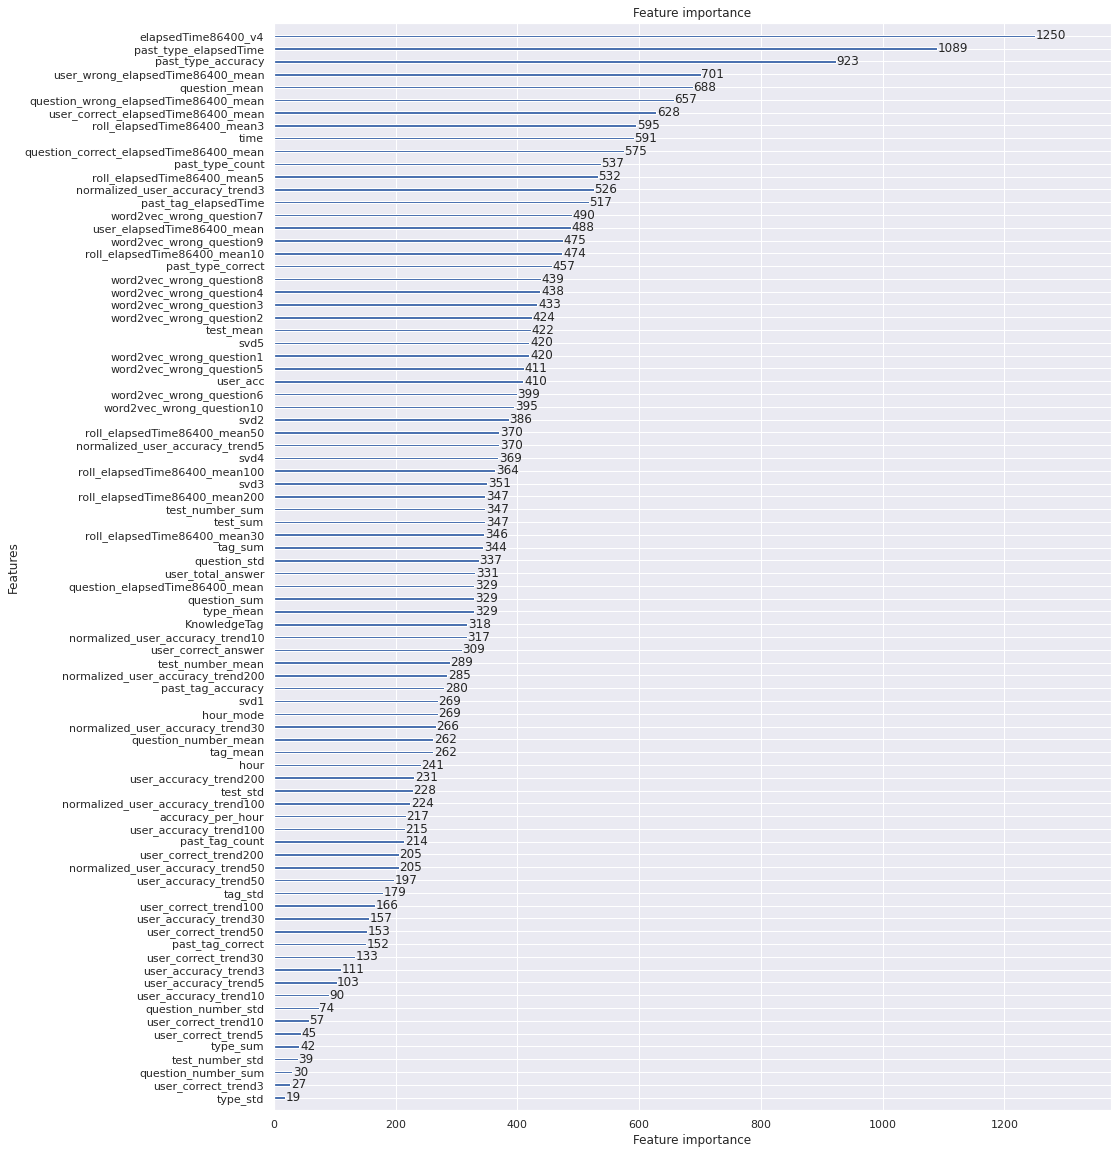

In [116]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model, figsize=(15,20))

## 5. Inference

In [118]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [119]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission5-1.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/submission5-1.csv
